In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [86]:
file_path = "../resources/data/output/customer_churn_prepared.csv"   
df = pd.read_csv(file_path)

In [87]:
df.head()

,call_failure,complains,subscription_length,charge_amount,seconds_of_use,frequency_of_SMS,distinct_called_numbers,age_group,tariff_plan,status,customer_value,churn
0,8,0,38,0,4370,5,17,3,1,1,197.640,0
1,0,0,39,0,318,7,4,2,1,2,46.035,0
2,10,0,37,0,2453,359,24,3,1,1,1536.520,0
3,10,0,38,0,4198,1,35,1,1,1,240.020,0
4,3,0,38,0,2393,2,33,1,1,1,145.805,0


In [88]:
X = df.drop(columns=["customer_value", "churn", ])
y = df["customer_value"]

In [89]:
y_log = np.log1p(y)

In [90]:
numeric_features = [
    "call_failure",
    "complains",
    "seconds_of_use",
    "frequency_of_SMS",
    "distinct_called_numbers",
    "charge_amount",
    "subscription_length"
]
categorical_features = [ "tariff_plan", "age_group", "status"]

In [91]:
# 2. Preprocessor
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(drop="first"), categorical_features)
])

In [92]:
# 3. Pipeline
baseline_tree = Pipeline([
    ("preprocessor", preprocessor),
    ("dt", DecisionTreeRegressor(random_state=42))
])


In [93]:
# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

In [94]:
# 5. Fit & predict
baseline_tree.fit(X_train, y_train)
y_pred = baseline_tree.predict(X_test)

In [95]:
# 6. Evaluate
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Decision Tree Regression - RMSE: {rmse:.2f}, R2 Score: {r2:.4f}")

Decision Tree Regression - RMSE: 0.01, R2 Score: 0.9909


In [96]:
residuals = y_test - y_pred

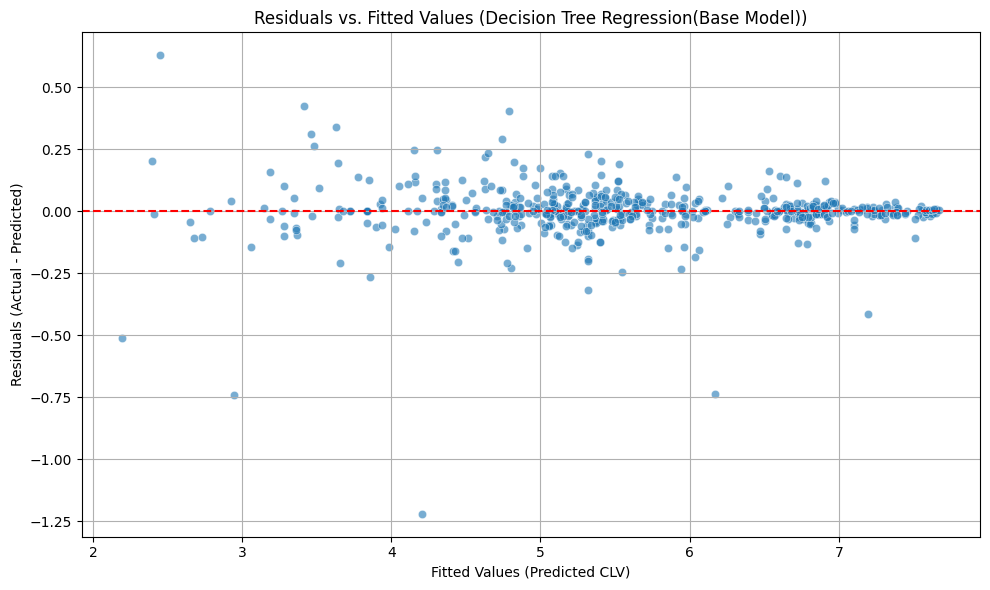

In [97]:

# Plot residuals vs fitted
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Fitted Values (Decision Tree Regression(Base Model))")
plt.xlabel("Fitted Values (Predicted CLV)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [98]:
from sklearn.model_selection import cross_val_score

# Reuse the same pipeline
neg_rmse_scores = cross_val_score(baseline_tree, X, y_log, scoring='neg_root_mean_squared_error', cv=5)
r2_scores = cross_val_score(baseline_tree, X, y_log, scoring='r2', cv=5)

print(f"\nCross-validated RMSE scores: {-neg_rmse_scores}")
print(f"Average RMSE: {-neg_rmse_scores.mean():.2f}")
print(f"Cross-validated R2 scores: {r2_scores}")
print(f"Average R2: {r2_scores.mean():.4f}")


Cross-validated RMSE scores: [0.08782355 0.120578   0.13951055 0.09788887 0.15727675]
Average RMSE: 0.12
Cross-validated R2 scores: [0.99427486 0.99047068 0.98744691 0.99278676 0.9803443 ]
Average R2: 0.9891


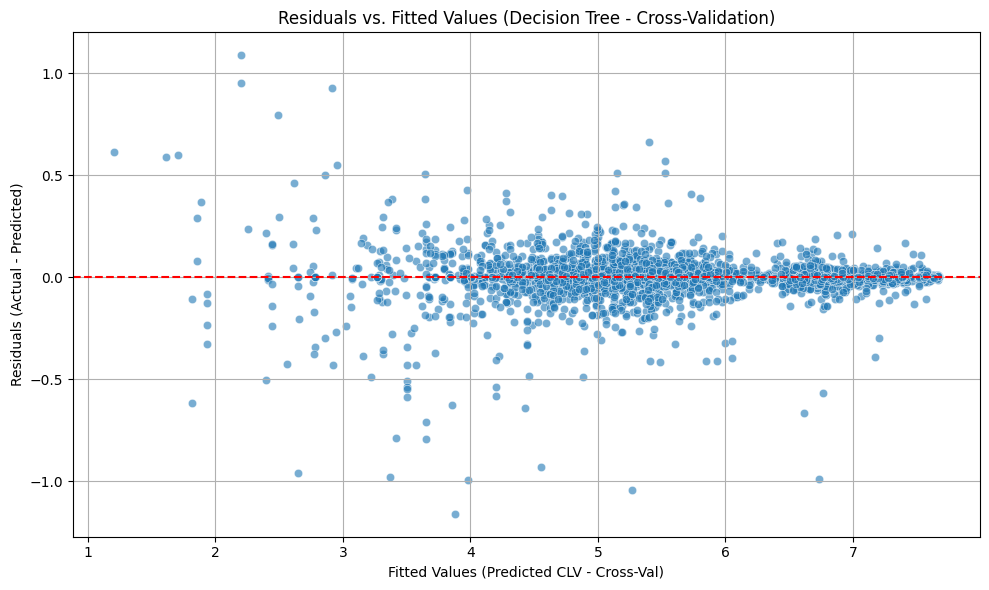

In [99]:
from sklearn.model_selection import cross_val_predict

# Get cross-validated predictions
y_pred_cv = cross_val_predict(baseline_tree, X, y_log, cv=5)

# Residuals
residuals_cv = y_log - y_pred_cv

# Plot: Residuals vs Fitted
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_cv, y=residuals_cv, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Fitted Values (Decision Tree - Cross-Validation)")
plt.xlabel("Fitted Values (Predicted CLV - Cross-Val)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.grid(True)
plt.tight_layout()
plt.show()

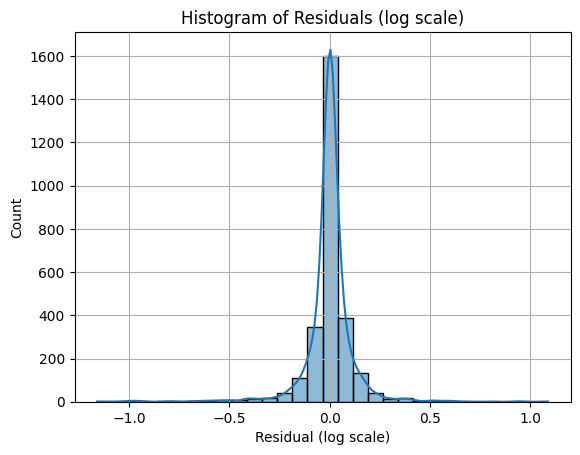

In [100]:
# Histogram (log residuals)
sns.histplot(residuals_cv, kde=True, bins=30)
plt.title("Histogram of Residuals (log scale)")
plt.xlabel("Residual (log scale)")
plt.grid(True)
plt.show()

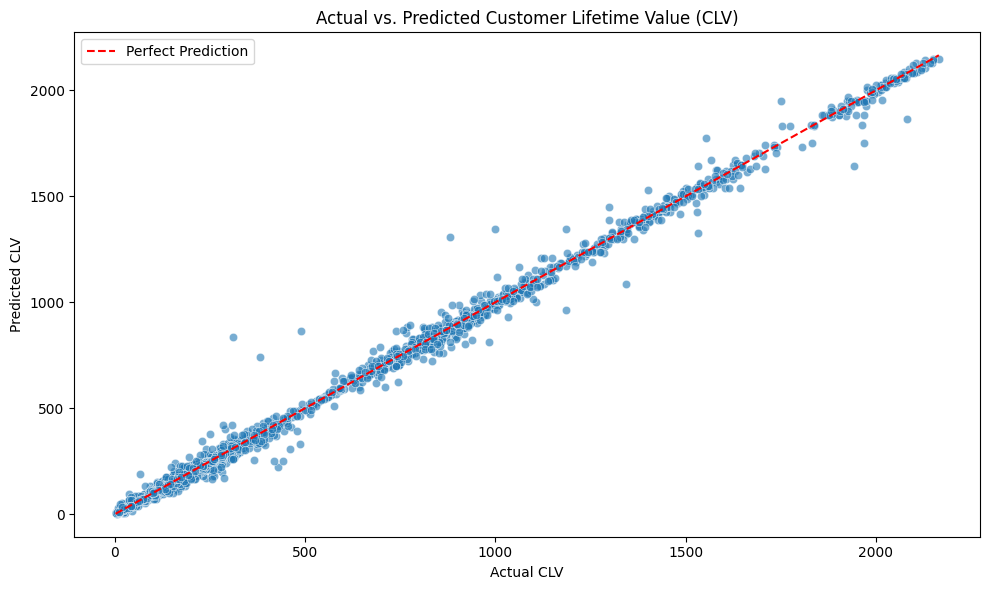

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = np.expm1(y_pred_cv)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y, y=y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()],
         color='red', linestyle='--', label='Perfect Prediction')

plt.xlabel("Actual CLV")
plt.ylabel("Predicted CLV")
plt.title("Actual vs. Predicted Customer Lifetime Value (CLV)")
plt.legend()
plt.tight_layout()
plt.show()


In [71]:
import joblib

# Fit the pipeline on the full training data
baseline_tree.fit(X, y_log)

# Save the entire pipeline to a file
joblib.dump(baseline_tree, '../resources/data/output/Decision_tree_regression_model_final.pkl')

['../resources/data/output/Decision_tree_regression_model_final.pkl']